# ARIMA on DJIA data
Student Name: Girija Madireddy           
Student id: x21235929                      
Master of Science in Data Analytics

In [1]:
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
np.set_printoptions(suppress=True)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import Image
import yfinance as yf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [2]:

# Define the ticker symbol for DJIA (Dow Jones Industrial Average)
ticker = "^DJI"

# Define the date range
start_date = "2012-01-01"
end_date = "2016-12-31"

# Use yfinance to get daily historical data
djia_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Reset index to get 'Date' as a column
djia_data.reset_index(inplace=True)

# Select the columns of interest
columns_of_interest = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']
djia_data = djia_data[columns_of_interest]

# Save the data as a CSV file
djia_data.to_csv('djia_data.csv', index=False)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Display the first few rows of the data
print(djia_data.head())

# Get data types and basic statistics
print(djia_data.info())
print(djia_data.describe())

        Date          Open          High           Low         Close  \
0 2012-01-03  12221.190430  12479.650391  12221.190430  12397.379883   
1 2012-01-04  12392.459961  12430.000000  12337.250000  12418.419922   
2 2012-01-05  12418.419922  12435.980469  12283.900391  12415.700195   
3 2012-01-06  12407.450195  12415.240234  12332.410156  12359.919922   
4 2012-01-09  12359.309570  12409.080078  12333.849609  12392.690430   

      Volume     Adj Close  
0  152560000  12397.379883  
1  145130000  12418.419922  
2  158440000  12415.700195  
3  131120000  12359.919922  
4  122200000  12392.690430  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   

In [4]:
djia_data_index = pd.read_csv("djia_data.csv",index_col='Date', parse_dates=['Date'])

<AxesSubplot:xlabel='Date'>

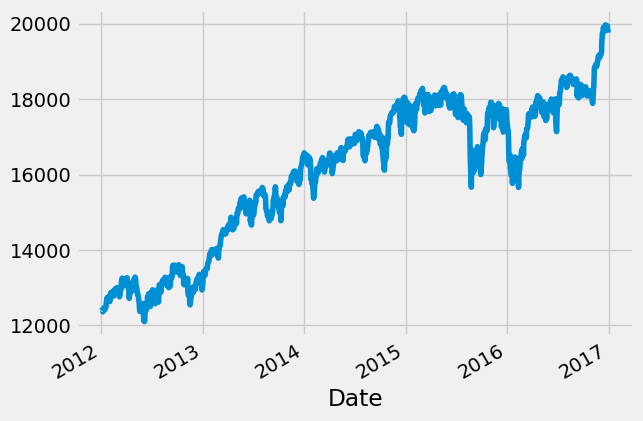

In [5]:
# DJIA data Close price plot 
djia_data_index.Close.plot()

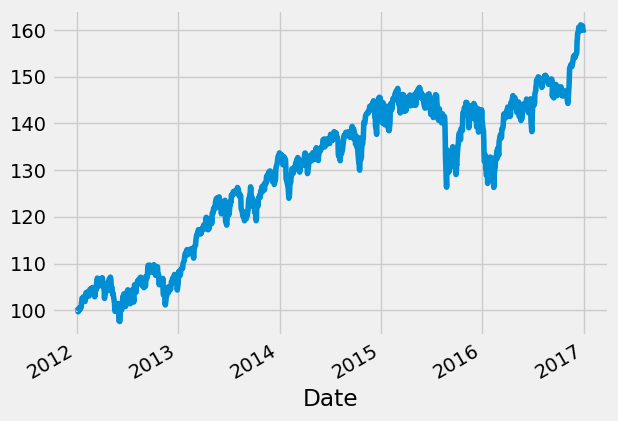

In [6]:
# DJIA Close price plot after normalizing data
norm_djia_stk = djia_data_index.Close.div(djia_data_index.Close.iloc[0]).mul(100)
norm_djia_stk.plot()
plt.show()

In [7]:
#Building Rangegslider plot
app = go.Scatter(
        x=djia_data['Date'], 
        y=djia_data['Close'],
        name='DJIA',
        line = dict(color = '#1E90FF')
    )

data = [app]

layout = dict(
    title='Time Series with Rangeslider for every 2 years from 2012 to 2016',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=2,
                     label='1Yrs',
                     step='year',
                     stepmode='backward'),
                dict(count=4,
                     label='4Yrs',
                     step='year',
                     stepmode='backward'),
                dict(count=6,
                     label='6Yrs',
                     step='year',
                     stepmode='backward'),
                dict(count=8,
                     label='8Yrs',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [8]:
# DJIA stock with respect to Open, High, Low and Close Price
djia_st = djia_data.iloc[:,:-2]

cf.set_config_file(offline=True, world_readable=True, theme='pearl')

djia_st.iplot(x='Date',kind='scatter', subplots=True, shape=(4,1), shared_xaxes=True,
            fill = True, title = "DJIA Stock w.r.t Open, High, Low and Close price")

In [9]:
#Creating Time series object for DJIA
djia_data = djia_data.sort_values(by = 'Date')
djia_data = djia_data.set_index('Date')
djia_ts = djia_data['Close']

In [10]:
#Function to check the stationarity
from statsmodels.tsa.stattools import adfuller

def st_check(timeseries):   
    rolmean = timeseries.rolling(12).mean() ## as month is year divide by 12
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

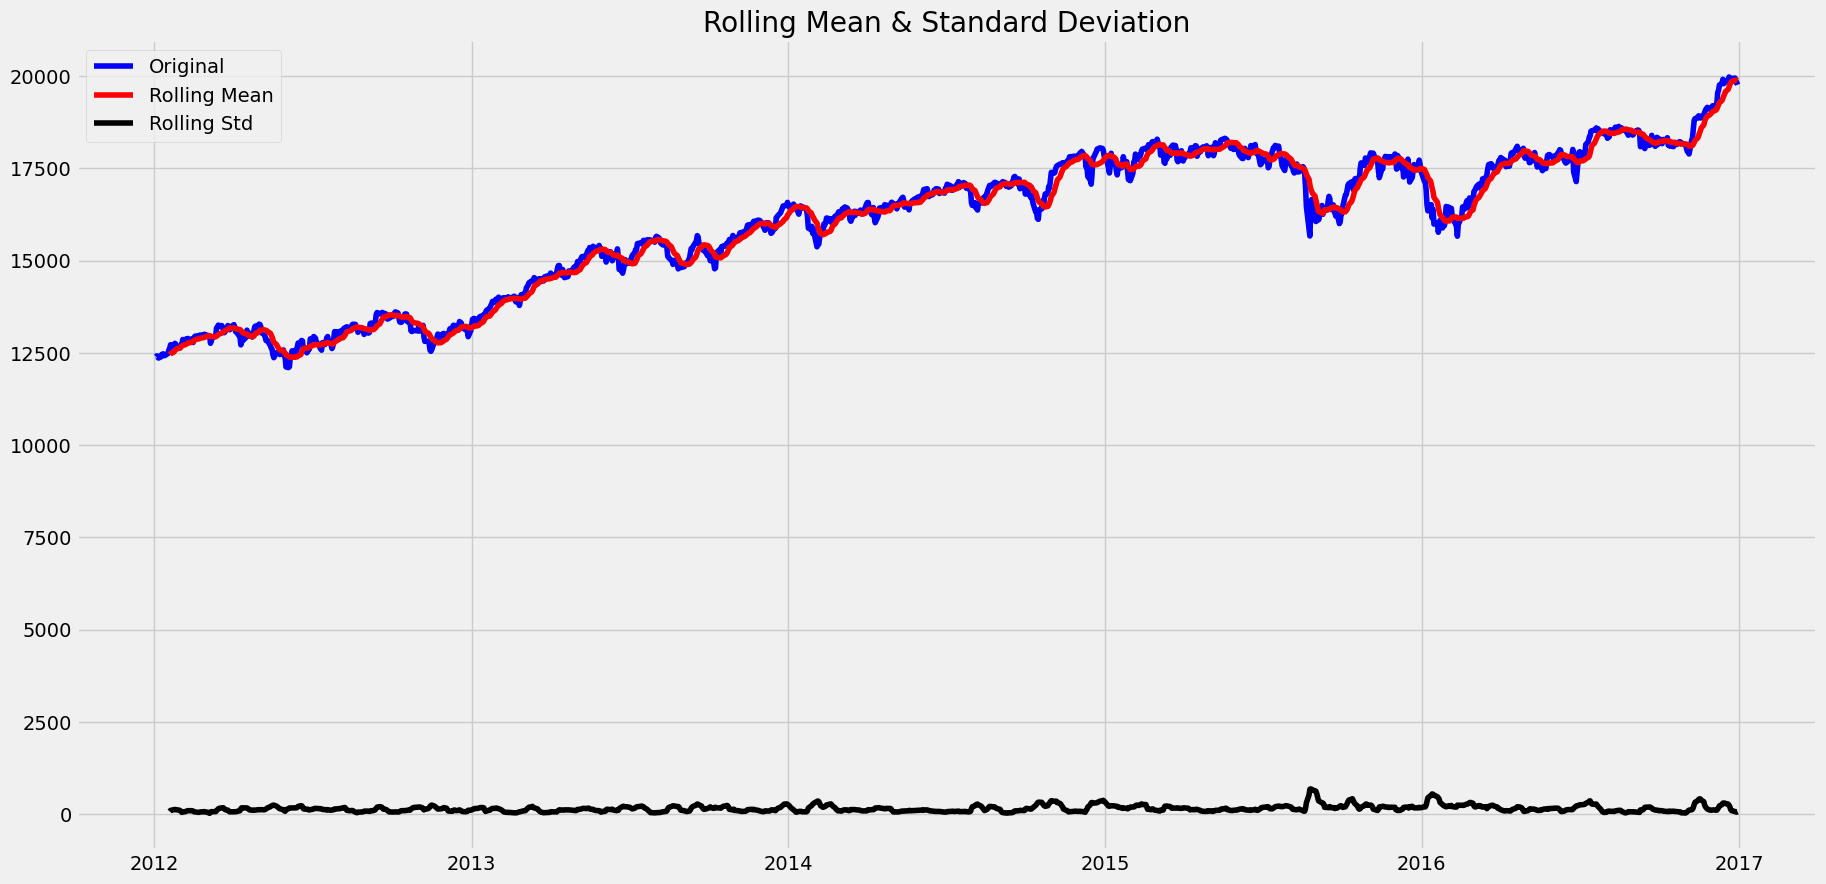

Results of Dickey-Fuller Test:
Test Statistic                   -1.115532
p-value                           0.708839
#Lags Used                        0.000000
Number of Observations Used    1257.000000
Critical Value (1%)              -3.435563
Critical Value (5%)              -2.863842
Critical Value (10%)             -2.567996
dtype: float64
None


In [11]:
print(st_check(djia_ts))

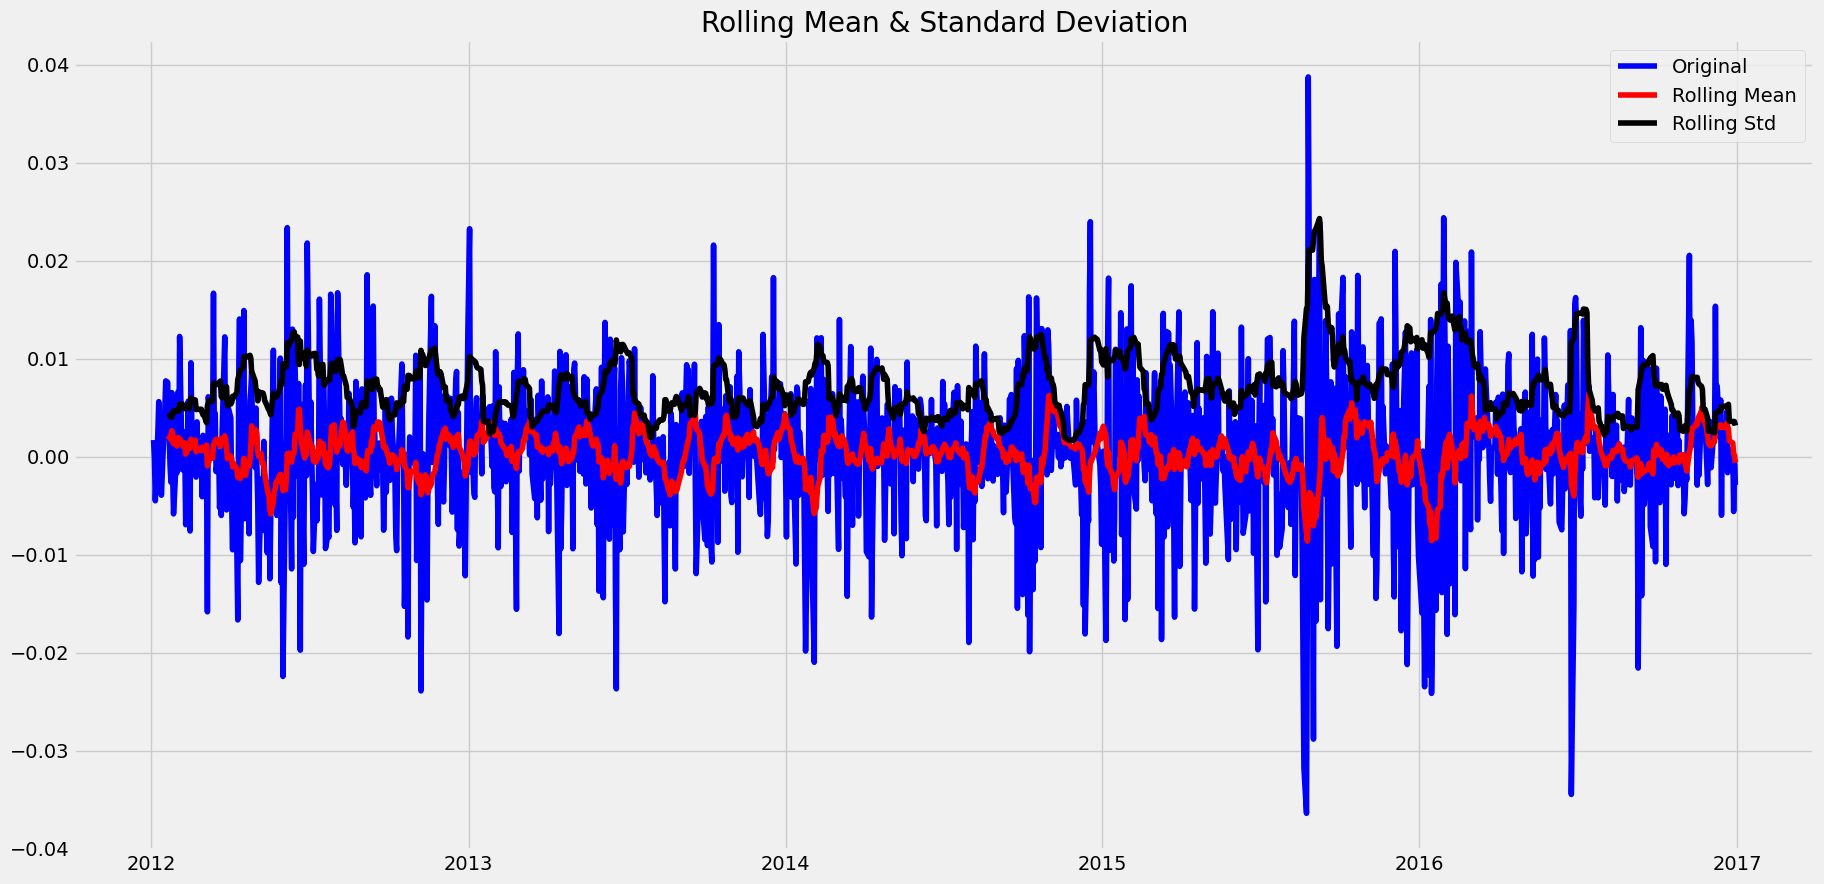

Results of Dickey-Fuller Test:
Test Statistic                  -36.134910
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (1%)              -3.435567
Critical Value (5%)              -2.863844
Critical Value (10%)             -2.567997
dtype: float64
None


In [12]:
#DJIA
djia_log=np.log(djia_ts)
djia_log_dif = djia_log - djia_log.shift()
djia_log_dif.dropna(inplace=True)
print(st_check(djia_log_dif))



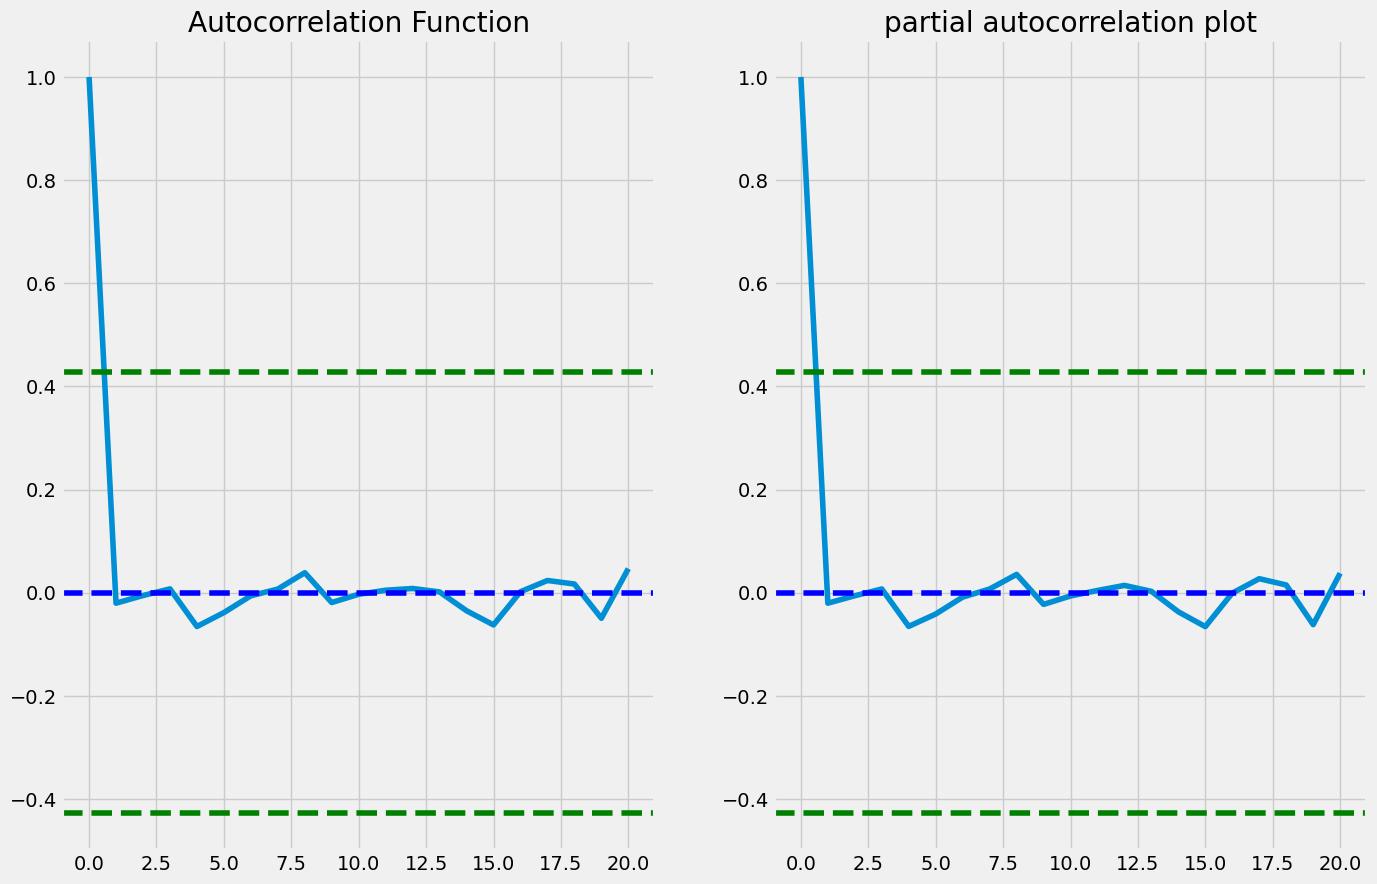

In [13]:
#ACF and PACF for DJIA stock
from statsmodels.tsa.stattools import acf,pacf

djia_lag_acf = acf(djia_log_dif,nlags=20)
djia_lag_pacf = pacf(djia_log_dif,nlags=20,method='ols')
f, axs = plt.subplots(2,2,figsize=(15,10))

######################### ACF ##########################################

plt.subplot(121)
plt.plot(djia_lag_acf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(djia_lag_acf)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(djia_lag_acf)),linestyle='--',color='green')
plt.title('Autocorrelation Function')


######################### PACF ##########################################

plt.subplot(122)
plt.plot(djia_lag_pacf)
plt.axhline(y=0,linestyle='--',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(djia_lag_pacf)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(djia_lag_pacf)),linestyle='--',color='green')
plt.title('partial autocorrelation plot')
plt.show()

In [14]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

In [15]:
# Define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, d, and q triplets
pdq = list(itertools.product(p, d, q))

# Define a DataFrame to store the results
results_df = pd.DataFrame(columns=['pdq', 'aic'])

# Grid search over parameter space
warnings.filterwarnings("ignore")  # Ignore convergence warnings
for param in pdq:
    try:
        model = ARIMA(djia_log, order=param)
        results = model.fit()
        results_df = results_df.append({'pdq': param, 'aic': results.aic}, ignore_index=True)
    except:
        continue

# Find the parameters with the lowest AIC
best_params = results_df.loc[results_df['aic'].idxmin()]

# Print the best parameters
print('Best ARIMA parameters:', best_params['pdq'])
print('AIC:', best_params['aic'])

Best ARIMA parameters: (0, 1, 0)
AIC: -8647.016937343375


In [16]:
# Split the data into training and validation sets based on the date
train = djia_log[:'2015-12-31']  # Everything up to and including the end of 2015
test = djia_log['2016-01-01':]  # Everything after 2015, so just 2016


In [17]:
# Fit the model on the training dataset
best_order = best_params['pdq']  
model = ARIMA(train, order=best_order)
fitted_model = model.fit()


In [18]:
# Forecast
n_forecast_steps = len(test)  # Forecast for the number of steps equal to the size of the test set
forecast = fitted_model.get_forecast(steps=n_forecast_steps)
fc = forecast.predicted_mean
conf = forecast.conf_int()

In [19]:
fc

1006    9.765663
1007    9.765663
1008    9.765663
1009    9.765663
1010    9.765663
          ...   
1253    9.765663
1254    9.765663
1255    9.765663
1256    9.765663
1257    9.765663
Name: predicted_mean, Length: 252, dtype: float64

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Exponentiating to get the original scale
# 'fc' is the array of forecasted log values, and 'test' contains the actual log values.
fc_original = np.exp(fc)
test_original = np.exp(test.values)  
# Calculating RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_original, fc_original))
mae = mean_absolute_error(test_original, fc_original)

print('RMSE:', rmse)
print('MAE:', mae)


RMSE: 1066.4629229741167
MAE: 886.4810074094744


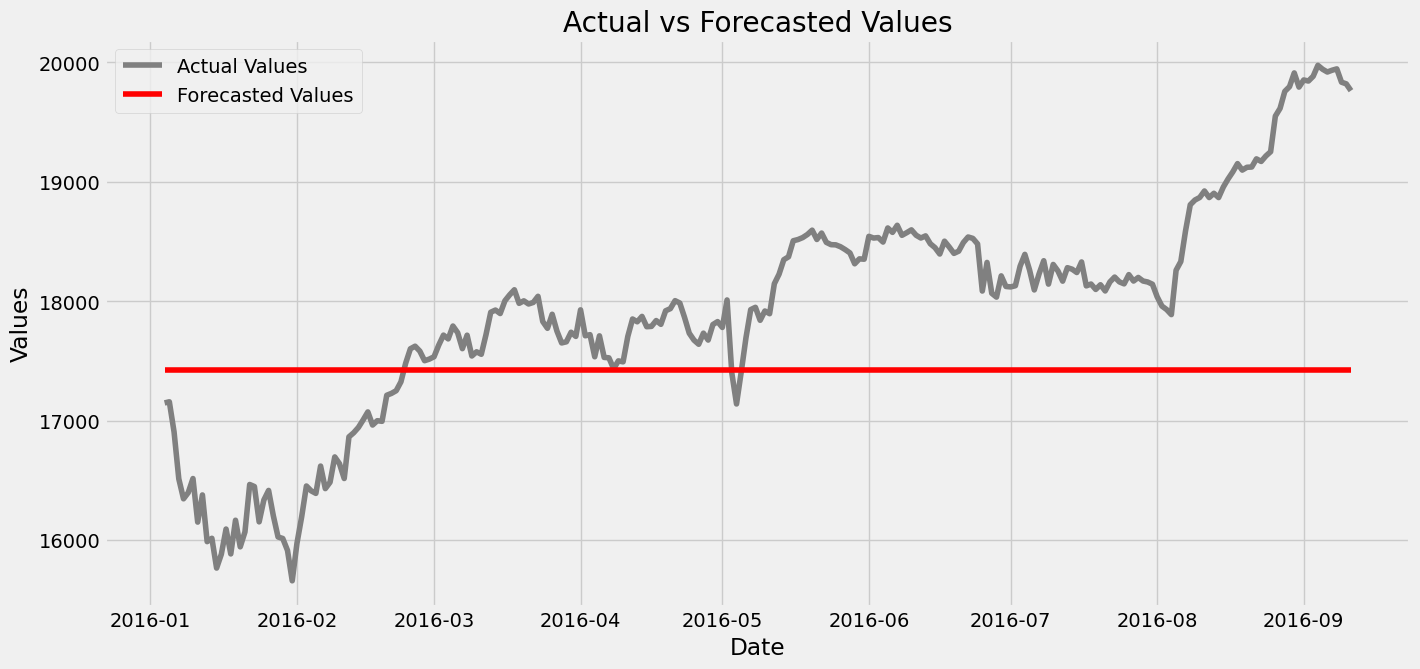

In [21]:
import matplotlib.pyplot as plt

# Create a date range for plotting
date_range = pd.date_range(start=test.index[0], periods=len(test), freq='D')

plt.figure(figsize=(15, 7))
plt.plot(date_range, test_original, label='Actual Values', color='grey')
plt.plot(date_range, fc_original, label='Forecasted Values', color='red')

plt.title('Actual vs Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()
